# Full MARS demo

This is the tutorial from the readme of MARS_Developer in Jupyter notebook form.

## 1. 📁 Create a new MARS Training Project

In [ ]:
from create_new_project import *

location = '/home/cristina/Desktop/ericykma/annotation_budget_projects'
name = '3000_frames_5_annotators'

create_new_project(location, name,
                   download_MARS_checkpoints=False,
                   download_demo_data=False)

Within your project folder is a file called `project_config.yaml`. This file contains many important features: keypoint and animal names, instructions for your annotation job, and names/data assignments for detection and pose models. Open this file in a text editor and fill in the fields as instructed in the comments.

# 2 Post-process the manual pose annotations
This script carries out several steps to create "ground truth" keypoint locations by taking the median across AWS workers, correct for left/right flips of body part labels, and package your data for model-training. The processed annotation data will be added as a new file to `annotation_data`.

In [2]:
import pose_annotation_tools.annotation_postprocessing
import importlib
importlib.reload(pose_annotation_tools.annotation_postprocessing)
from pose_annotation_tools.annotation_postprocessing import *

project_path = '/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators'
annotation_postprocessing(project_path)

Instructions for updating:
non-resource variables are not supported in the long term
Processing manifest file...
  frame 1000
  frame 2000
Ground-truth keypoint locations extracted!
DID NOT SHUFFLE
Generating black_top detection training files...
done.
Generating top pose training files...
done.
Generating black_top priors...
done.


### 2.4 Visualize some manual pose annotations

We'll next take a look at the inter-annotator variability in your pose labels, as this is a good predictor for how well MARS will perform. (If you annotated pose yourself you can skip this step.)

To look at annotations on an example frame, call `plot_frame`. It takes as input a project path and a number (specifying the image in your annotation dataset.) It also takes two optional plotting arguments:
* `markersize` the size of the keypoint makers (default is 8)
* `figsize` the width and height of the plot (default is [15,20])

The colored points are the raw annotation data. Points are colored by body part, and all points of a given marker shape come from the same worker. The black and white points are the medians across annotators. These medians are the "ground truth" that we'll use to train MARS.

In [ ]:
from pose_annotation_tools.evaluation import *

project_path = '/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators'
frame_num = 42  # the frame number to look at in your data

plot_frame(project_path,frame_num, markersize=5, figsize=[10,10])

To summarize worker performance, we'll look at the **Percent Correct Keypoints (PCK)**. This is the percentage of keypoints from individual workers that fall within a radius X of the "ground truth" worker median.

For each keypoint, we compute the distance from each worker's annotation to the median of the remaining workers, on each frame. We then plot cdfs of **median** (dashed line) worker-to-median distances for each frame, as well as a shaded area whose upper and lower bounds are the min and max worker-to-median distances, respectively.

The "all" plot takes the framewise average across keypoints, for each metric.

`plot_human_PCK` summarizes worker performance for your dataset. It takes four optional arguments:
* `animal_names` specifies which animals to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools data across animal types in your dataset.

In [ ]:
from pose_annotation_tools.evaluation import *

project_path = '/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators'
plot_human_PCK(project_path, combine_animals=False)

## 3. 🎯 Fine-tune the MARS detector to your data


### 3.1 Run the training code
`run_training` takes two optional arguments:
* `models` takes names of detectors to train, in case you only want to work on one detector at a time (MARS trains all detectors sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml` (300,000 by default). You can set this to a small number to confirm everything is working before launching your full training job.

If training is interrupted, it will resume from the most recent model checkpoint; MARS saves checkpoints every 30 minutes (adjust this in `my_project/detection/train_config.yaml`), and when training completes.

In [33]:
from multibox_detection import train_detect
import importlib
importlib.reload(train_detect)

project_path = '/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators'
train_detect.run_training(project_path, max_training_steps=2000)

/home/cristina/Desktop/ericykma/m_dev_fork/MARS_Developer/multibox_detection/train_detect.py:398: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bbox_priors = np.array(bbox_priors).astype(np.float32)
VAL CHANGE HERE
VAL CHANGE HERE
VAL CHANGE HERE
CHANGES MADE AGAIN AND AGAIN
b
/home/cristina/Desktop/ericykma/pretrained_models_for_MARS/detection_inception_resnet_v2/inception_resnet_v2_2016_08_30.ckpt
/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators/detection/black_top_log
/home/cristina/Desktop/ericykma/pretrained_models_for_MARS/detection_inception_resnet_v2/inception_resnet_v2_2016_08_30.ckpt
INFO:tensorflow:Fine-tuning from /home/cristina/Desktop/ericykma/pretrained_models_for_MARS/detection_inception_resnet_v2/inception_resnet_v2_2

In [5]:
import new_eval as eval
import importlib
importlib.reload(eval)
project_path = '/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators'
eval.run_evaluation(project_path)

/home/cristina/Desktop/ericykma/m_dev_fork/MARS_Developer/new_eval.py:289: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bbox_priors = np.array(bbox_priors).astype(np.float32)
INFO:tensorflow:Restoring parameters from /home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators/detection/black_top_log/model.ckpt-100000
Found model for global step: 100000
Step: 1, Time/image (ms): 643.2
Step: 2, Time/image (ms): 12.7
Step: 3, Time/image (ms): 12.6
Step: 4, Time/image (ms): 12.6
Step: 5, Time/image (ms): 12.6
Step: 6, Time/image (ms): 12.5
Step: 7, Time/image (ms): 12.6
Step: 8, Time/image (ms): 12.5
Step: 9, Time/image (ms): 12.7
Step: 10, Time/image (ms): 12.6
Step: 11, Time/image (ms): 12.5
Step: 12, Time/image (ms): 12.6
Step: 13, Time/image (m

loaded


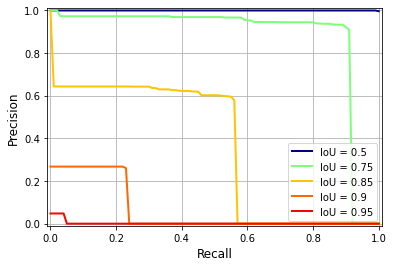

In [6]:
import multibox_detection.prcurve_separate
importlib.reload(multibox_detection.prcurve_separate)
from multibox_detection.prcurve_separate import *
prcurve(project_path)

In [7]:
from multibox_detection import evaluate_detection
import importlib
importlib.reload(evaluate_detection)
evaluate_detection.save_best_checkpoint(project_path)

Saved best-performing checkpoint for model "black_top."


In [8]:
performance = evaluate_detection.run_test(project_path)

detecting using black_top
/home/cristina/Desktop/ericykma/m_dev_fork/MARS_Developer/multibox_detection/evaluate_detection.py:546: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bbox_priors = np.array(bbox_priors).astype(np.float32)
/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators/detection/black_top_model
is now:/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators/detection/black_top_model/model.ckpt-92643
INFO:tensorflow:Restoring parameters from /home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators/detection/black_top_model/model.ckpt-92643
Found model for global step: 92643


Sample frame for black_top detector:
['/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators/annotation_data/test_sets/black_top_detection/test0000000_image0002750_MARS_top_14750.jpg']
50
[{'image_id': 50, 'bbox': [0.7417292594909668, 0.5690023899078369, 0.20964771509170532, 0.3005552291870117], 'score': 0.9934927225112915, 'category_id': 1}, {'image_id': 50, 'bbox': [0.6877540349960327, 0.569156289100647, 0.29740649461746216, 0.430843710899353], 'score': 0.001575171947479248, 'category_id': 1}, {'image_id': 50, 'bbox': [0.8648433089256287, 0.4393560290336609, 0.13515669107437134, 0.36814725399017334], 'score': 0.0013329088687896729, 'category_id': 1}, {'image_id': 50, 'bbox': [0.8922844529151917, 0.405623197555542, 0.10771554708480835, 0.3672215938568115], 'score': 0.001309812068939209, 'category_id': 1}, {'image_id': 50, 'bbox': [1.0, 0.5701060891151428, -0.12682616710662842, 0.11963492631912231], 'score': 0.0012831687927246094, 'category_id': 1}, {'imag

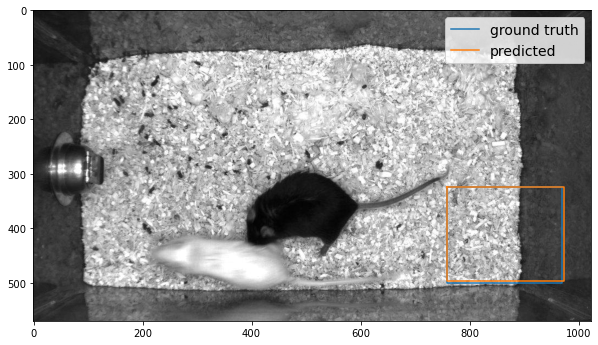

In [32]:
from multibox_detection import evaluate_detection
import importlib
importlib.reload(evaluate_detection)
project_path = '/home/cristina/Desktop/ericykma/annotation_budget_projects/3000_frames_5_annotators'
frame_num = 1
evaluate_detection.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10], confidence_thr=0.2)

### 3.3 Evaluate model performance on a held-out test set

After picking the checkpoint that performs best on your validation set, we can evaluate that model's performance on the test set:


First, we'll run our selected model on the test set. `run_test` takes optional arguments:
* `detector_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [ ]:
from multibox_detection import evaluate_detection

project_path = '/home/cristina/Desktop/ericykma/reproduce'
performance = evaluate_detection.run_test(project_path)

First, let's look at ground truth and predicted bounding boxes for a sample frame. The `Multibox Detection` model makes multiple object detection predictions, each with an associated confidence value.

MARS keeps only the box with the highest confidence score, however when plotting we also show all predicted bounding boxes with a confidence of 0.75 or higher. To change this threshold, modify the optional `confidence_thr` argument to be some value between 0 (lowest) and 1 (highest).

In [ ]:
from multibox_detection import evaluate_detection

project_path = '/home/cristina/Desktop/ericykma/reproduce'
frame_num = 5

evaluate_detection.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10], confidence_thr=0.75)

Now let's get some summary statistics using the COCO API. The most common metric for evaluating detector performance is the **Intesection over Union (IoU)** - the ratio of the area of overlap between ground truth and predicted boxes, divided by the union of their areas- ie $(\textrm{ground truth} \cap \textrm{predicted})/(\textrm{ground truth} \cup \textrm{predicted})$.

We'll report the **mean Average Precision** and **mean Average Recall** (mAP and mAR) of the IoU, which are the average of Precision and Recall values computed over a range of thresholds on IoU values. This is a standard method for evaluating object detector performance; see the MARS manuscript for an explanation of this metric, or [this article](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3) for further reading.

In [ ]:
performance = evaluate_detection.coco_eval(project_path)

for model in performance.keys():
    print('Performance for ' + model + ':')
    performance[model].summarize()

Finally, we'll plot **PR Curves**, showing the Precision vs Recall of our detector for various confidence thresholds. Line color here indicates the minimum IoU required to be counted as a correct detection.

In [ ]:
from multibox_detection import evaluate_detection

project_path = '/home/cristina/Desktop/ericykma/reproduce'
evaluate_detection.pr_curve(project_path)